# **Klasifikasi Sinyal Elektrokardiogram (ECG) pada Dataset ECG5000**

## **Bussines Understanding**
Pemeriksaan Electrocardiogram (ECG) merupakan metode utama untuk mendeteksi gangguan irama dan aktivitas jantung. Dalam praktik klinis, jumlah rekaman sinyal ECG bisa sangat banyak dan membutuhkan analisis yang cepat dan akurat. Proses analisis manual oleh tenaga medis memakan waktu, sehingga diperlukan sistem yang mampu mengklasifikasikan pola sinyal ECG secara otomatis.

Dataset ECG5000 menyediakan data time-series detak jantung yang terdiri dari lima jenis pola:

- Normal
- R-on-T Premature Ventricular Contraction (R-On-T PVC)
- Premature Ventricular Contraction (PVC)
- Supraventricular Premature Beat
- Unclassified Beat

**Identifikasi Sumber Data dan Infrastruktur**

Data ini bersumber dari ekosistem PhysioNet, sebuah inisiatif kolaborasi penelitian yang memiliki tiga komponen utama yang saling terkait:
- PhysioBank: Berperan sebagai arsip digital skala besar yang menyimpan rekaman sinyal fisiologis terkarakterisasi, termasuk basis data sinyal kardiopulmoner dari pasien dengan kondisi gagal jantung kongestif (congestive heart failure).
- PhysioToolkit: Menyediakan pustaka perangkat lunak open-source untuk pemrosesan sinyal dan deteksi peristiwa fisiologis penting, yang memungkinkan pembuatan basis data baru dari rekaman mentah.
- PhysioNet: Berfungsi sebagai forum online untuk diseminasi, pertukaran data, dan evaluasi algoritma baru bagi komunitas biomedis.

**Proses Akuisisi Data**

Dataset ECG5000 diolah dari rekaman asli berdurasi 20 jam yang berasal dari pasien pria berusia 48 tahun dengan kondisi gagal jantung kongestif berat (BIDMC Congestive Heart Failure Database, rekaman chf07). Rekaman mentah tersebut awalnya memiliki 17.998.834 titik data yang mencakup total 92.584 detak jantung


Paper sumber data asli: *PhysioBank, PhysioToolkit, and PhysioNet : Components of a New Research Resource for Complex Physiologic Signals*

Paper pertama pengguna ecg5000: http://alumni.cs.ucr.edu/~ychen053/NEL_Journal.pdf


### **Tujuan Analisis**
Tujuan dari proyek ini adalah untuk membangun model klasifikasi yang mampu mengidentifikasi jenis pola sinyal ECG berdasarkan data time-series dari dataset ECG5000. Model yang dibuat diharapkan dapat:
- Membedakan sinyal ECG normal dan tidak normal.
- Memprediksi jenis kelainan detak jantung berdasarkan pola sinyal
- Membandingkan beberapa model klasifikasi misal knn-dtw, random forest, dan Svm

## **Understanding Data (EDA)**
ECG5000 adalah dataset time-series yang berisi sinyal Electrocardiogram (ECG) dari berbagai pasien. Setiap data merupakan satu siklus detak jantung yang telah dinormalisasi dan dipotong menjadi panjang yang sama.

Dataset ini berasal dari Beth Israel Deaconess Medical Center dan merupakan bagian dari PhysioNet / UCR Time Series Classification Archive. Dataset ini juga terdiri dari 500 data train dan 4500 data test, 140 fitur → nilai amplitudo sinyal ECG pada setiap time-step dan 1 label kelas (di kolom terakhir)

### **Load Dataset**
link GDrive dataset ecg5000: https://drive.google.com/drive/folders/1PM-IbBccdFeRQgRgV_ZlmIPRiqZwOtjV?usp=sharing

In [12]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [13]:
from scipy.io import arff
import pandas as pd
import numpy as np

train_path = "/workspaces/PSD/tugas/UAS/ECG5000_TRAIN.arff"
test_path  = "/workspaces/PSD/tugas/UAS/ECG5000_TEST.arff"

# Load data
train_data, _ = arff.loadarff(train_path)
test_data,  _ = arff.loadarff(test_path)

# Convert ke DataFrame
df_train = pd.DataFrame(train_data)
df_test  = pd.DataFrame(test_data)

# ARFF punya label di kolom terakhir bernama 'target'
print(df_train.head())

       att1      att2      att3      att4      att5      att6      att7  \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

       att8      att9     att10  ...    att132    att133    att134    att135  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

     att136    att137    att138    att139    att140  target  
0  0.2

### **Ukuran Dataset**

In [14]:
# Gabungkan seluruh data untuk analisis
df = pd.concat([df_train, df_test], ignore_index=True)

# Label biasanya dalam bentuk byte -> convert ke int
df['target'] = df['target'].astype(int)

print(df.shape)

(5000, 141)


### **Cek Missing Value**

In [15]:
print("=== Missing Value ===")
print(df.isnull().sum().sum(), "total missing value")


=== Missing Value ===
0 total missing value


### **Distribusi Kelas (Imbalance)**

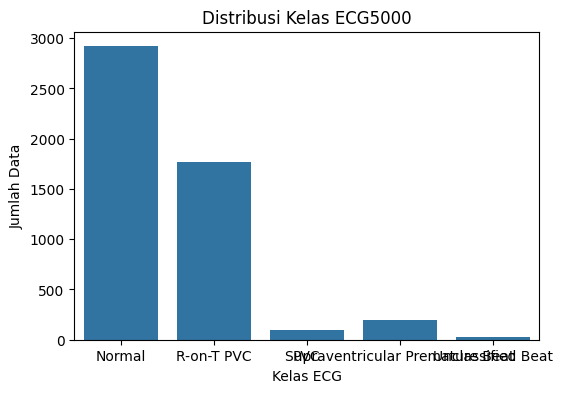

class_name
Normal                             2919
R-on-T PVC                         1767
Supraventricular Premature Beat     194
PVC                                  96
Unclassified Beat                    24
Name: count, dtype: int64


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# df['target'] sudah berisi int 1–5
mapping = {
    1: "Normal",
    2: "R-on-T PVC",
    3: "PVC",
    4: "Supraventricular Premature Beat",
    5: "Unclassified Beat"
}
df['class_name'] = df['target'].map(mapping)

plt.figure(figsize=(6,4))
sns.countplot(x=df['class_name'])
plt.title("Distribusi Kelas ECG5000")
plt.xlabel("Kelas ECG")
plt.ylabel("Jumlah Data")
plt.show()

print(df['class_name'].value_counts())


### **Plot Contoh Sinyal per Kelas**

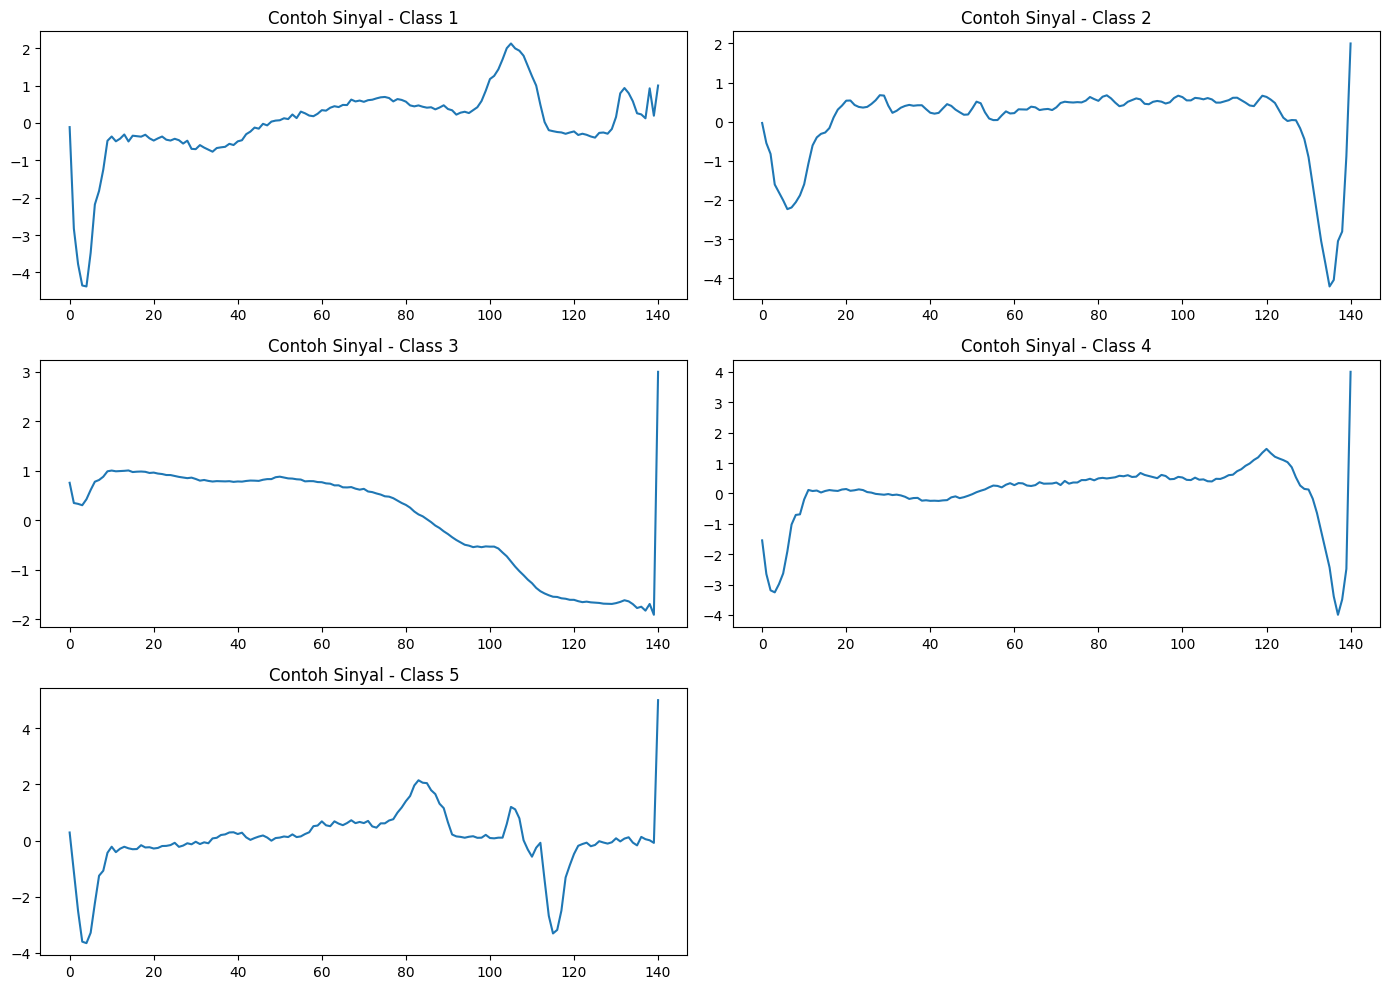

In [17]:
# ambil nama kolom fitur (kecuali target)
feature_cols = df.columns[:-1]

# sample sinyal dari setiap kelas
plt.figure(figsize=(14,10))

classes = sorted(df['target'].unique())

for i, c in enumerate(classes, 1):
    sample = df[df['target'] == c].iloc[0][feature_cols].values
    plt.subplot(3, 2, i)
    plt.plot(sample)
    plt.title(f"Contoh Sinyal - Class {c}")
    plt.tight_layout()

plt.show()


 Hasil Deteksi Outlier
Jumlah Outlier terdeteksi: 101
Persentase Outlier: 2.02%


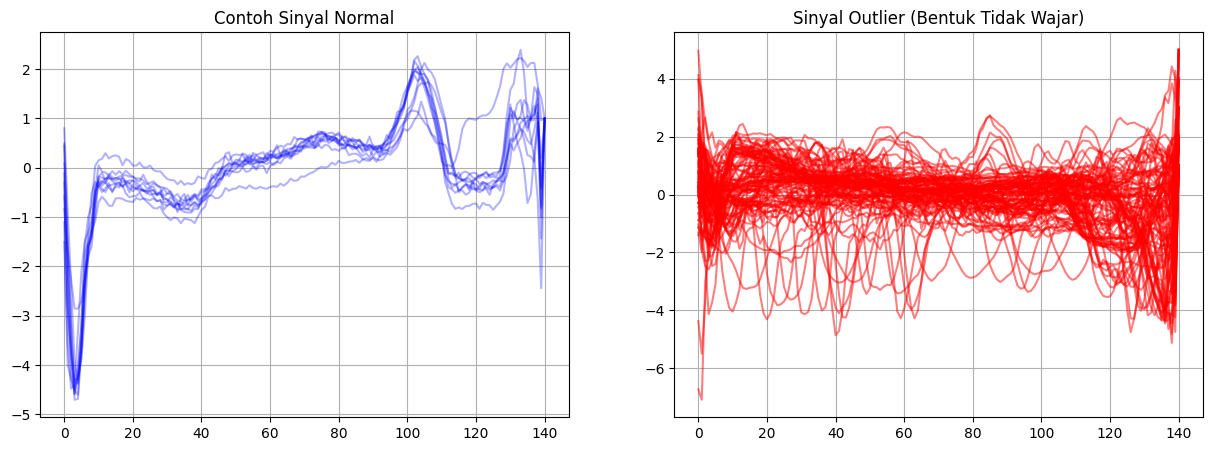

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# df berisi 140 kolom fitur dan 1 kolom 'target' di akhir
# pisahkan fitur untuk menghitung statistik
fitur_columns = df.columns[:-1]
data_fitur = df[fitur_columns]

# 1. Menghitung 'Mean Euclidean Distance' sebagai skor pencilan
# hitung rata-rata global dari seluruh sinyal
rata_rata_global = data_fitur.mean(axis=0)

# Hitung jarak setiap sampel ke rata-rata global
distansi = np.sqrt(((data_fitur - rata_rata_global) ** 2).sum(axis=1))

# 2. Menentukan Threshold menggunakan metode IQR
Q1 = distansi.quantile(0.25)
Q3 = distansi.quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR

# Identifikasi outlier
outliers = df[distansi > threshold]
clean_data = df[distansi <= threshold]

print(f" Hasil Deteksi Outlier")
print(f"Jumlah Outlier terdeteksi: {len(outliers)}")
print(f"Persentase Outlier: {(len(outliers)/len(df))*100:.2f}%")

# 3. Visualisasi Perbandingan
plt.figure(figsize=(15, 5))

# Plot Sinyal Normal (Acak)
plt.subplot(1, 2, 1)
for i in range(min(10, len(clean_data))):
    plt.plot(clean_data.iloc[i, :-1].values, color='blue', alpha=0.3)
plt.title("Contoh Sinyal Normal")
plt.grid(True)

# Plot Sinyal Outlier
plt.subplot(1, 2, 2)
if len(outliers) > 0:
    for i in range(len(outliers)):
        plt.plot(outliers.iloc[i, :-1].values, color='red', alpha=0.5)
    plt.title("Sinyal Outlier (Bentuk Tidak Wajar)")
else:
    plt.text(0.5, 0.5, 'Tidak ada outlier terdeteksi', ha='center')

plt.grid(True)
plt.show()

In [19]:
# Menggunakan data yang sudah bersih dari outlier
df_final = clean_data.copy()

print(f"Ukuran dataset sebelum dibersihkan: {df.shape}")
print(f"Ukuran dataset setelah outlier dihapus: {df_final.shape}")

# Reset index agar rapi kembali
df_final.reset_index(drop=True, inplace=True)

 # Tentukan path penyimpanan (sesuaikan dengan folder kerja Anda)
output_path = "/workspaces/PSD/tugas/UAS/ECG5000_Cleaned.csv"


# Simpan ke CSV
# index=False agar tidak menambah kolom baru (Unnamed: 0)
df_final.to_csv(output_path, index=False)

print(f"✅ Dataset berhasil disimpan ke: {output_path}")

Ukuran dataset sebelum dibersihkan: (5000, 142)
Ukuran dataset setelah outlier dihapus: (4899, 142)
✅ Dataset berhasil disimpan ke: /workspaces/PSD/tugas/UAS/ECG5000_Cleaned.csv


## **Pre Processing**
Tahap preprocessing ini mengikuti prinsip standardisasi data fisiologis yang dikemukakan dalam PhysioToolkit, di mana sinyal harus bebas dari variasi teknis agar fitur morfologis jantung dapat terlihat jelas. Selain itu, teknik penyeimbangan kelas diterapkan untuk mengakomodasi distribusi data dari rekaman chf07 yang secara alami memiliki lebih banyak detak jantung normal daripada anomali.

### **Normalisasi Data menggunakan Min-Max Scalling**

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. Menentukan kolom fitur (140 titik waktu)
# abaikan kolom 'target' dan 'class_name' saat normalisasi
feature_cols = df_final.columns.drop(['target', 'class_name'])

# 2. NORMALISASI (Min-Max Scaling)
# Mengubah rentang nilai sinyal menjadi 0 sampai 1 agar model lebih stabil
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_final[feature_cols])

# 3. PENGGABUNGAN KEMBALI
# Membuat DataFrame baru untuk hasil preprocessing
df_preprocessed = pd.DataFrame(X_scaled, columns=feature_cols)
df_preprocessed['target'] = df_final['target'].values  # Mengambil nilai integer asli

print("✅ Preprocessing Selesai")
print(f"Bentuk data: {df_preprocessed.shape}")
print(f"Rentang nilai fitur (Min): {df_preprocessed[feature_cols].values.min()}")
print(f"Rentang nilai fitur (Max): {df_preprocessed[feature_cols].values.max()}")
print("\nStatistik per-kelas (setelah normalisasi):")
print(df_preprocessed.groupby('target').size())

✅ Preprocessing Selesai
Bentuk data: (4899, 141)
Rentang nilai fitur (Min): 0.0
Rentang nilai fitur (Max): 1.0000000000000002

Statistik per-kelas (setelah normalisasi):
target
1    2891
2    1716
3      87
4     188
5      17
dtype: int64


### **Split Data dan Menyeimbangkan Data dengan SMOTE**
SMOTE bekerja dengan cara membuat sampel "sintetis" baru untuk kelas minoritas (2, 3, 4, dan 5), bukan sekadar menduplikasi data yang sudah ada. Teknik ini menciptakan titik data baru di antara sampel yang sudah ada sehingga model dapat mempelajari batas keputusan (decision boundary) yang lebih baik untuk deteksi penyakit jantung

In [21]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

# 1. PISAHKAN FITUR DAN TARGET
X = df_preprocessed.drop(columns=['target'])
y = df_preprocessed['target']

# 2. STRATIFIED TRAIN-TEST SPLIT
# Stratify=y memastikan proporsi kelas di train dan test sama dengan aslinya
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Jumlah data Train asli: {len(y_train)}")
print(f"Jumlah data Test (Murni): {len(y_test)}")
print(f"Distribusi kelas di y_train sebelum SMOTE: {Counter(y_train)}")

# 3. TERAPKAN SMOTE HANYA PADA DATA TRAIN
# Ini mencegah 'Data Leakage' karena model tidak pernah melihat data sintetis di data uji
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("-" * 30)
print(f"Distribusi kelas di y_train setelah SMOTE: {Counter(y_train_balanced)}")
print(f"Distribusi kelas di y_test (Tetap Asli): {Counter(y_test)}")

Jumlah data Train asli: 3919
Jumlah data Test (Murni): 980
Distribusi kelas di y_train sebelum SMOTE: Counter({1: 2313, 2: 1373, 4: 150, 3: 69, 5: 14})
------------------------------
Distribusi kelas di y_train setelah SMOTE: Counter({2: 2313, 1: 2313, 4: 2313, 3: 2313, 5: 2313})
Distribusi kelas di y_test (Tetap Asli): Counter({1: 578, 2: 343, 4: 38, 3: 18, 5: 3})


## **Modelling Data**


### **Random Forest**
Model Random Forest adalah algoritma machine learning yang menggabungkan banyak decision tree (pohon keputusan) untuk menghasilkan prediksi yang lebih akurat dan stabil, dengan mengurangi overfitting (terlalu spesifik pada data latih). Cara kerjanya adalah membangun banyak pohon keputusan secara paralel, di mana setiap pohon dilatih pada sampel data dan subset fitur yang berbeda (acak), lalu hasil akhirnya didapat dari pemungutan suara mayoritas (klasifikasi) atau rata-rata (regresi) dari semua pohon tersebut

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# 1. Inisialisasi Model
# n_estimators=100 (jumlah pohon), n_jobs=-1 (menggunakan semua core CPU agar cepat)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Pelatihan pada Data yang sudah di-SMOTE
print("⏳ Melatih Random Forest pada data seimbang...")
model_rf.fit(X_train_balanced, y_train_balanced)

# 3. Prediksi pada Data Test Murni
y_pred = model_rf.predict(X_test)

# 4. Evaluasi
print("\n✅ Hasil Klasifikasi pada Data Uji Asli:")
print(f"Akurasi: {accuracy_score(y_test, y_pred):.4f}")
print("\nDetail Per-Kelas:")
target_names = ["Normal", "R-on-T PVC", "PVC", "Supraventricular", "Unclassified"]
print(classification_report(y_test, y_pred, target_names=target_names))

⏳ Melatih Random Forest pada data seimbang...

✅ Hasil Klasifikasi pada Data Uji Asli:
Akurasi: 0.9541

Detail Per-Kelas:
                  precision    recall  f1-score   support

          Normal       0.98      1.00      0.99       578
      R-on-T PVC       0.94      0.97      0.95       343
             PVC       0.58      0.61      0.59        18
Supraventricular       0.71      0.39      0.51        38
    Unclassified       0.00      0.00      0.00         3

        accuracy                           0.95       980
       macro avg       0.64      0.59      0.61       980
    weighted avg       0.95      0.95      0.95       980



/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### **1D CNN**
Model CNN (Convolutional Neural Network) adalah jenis jaringan saraf tiruan (deep learning) yang dirancang khusus untuk menganalisis data visual seperti gambar, dengan cara mengidentifikasi pola-pola lokal secara otomatis melalui lapisan konvolusi, menjadikannya sangat efektif untuk tugas-tugas seperti klasifikasi, deteksi, dan segmentasi objek, contohnya pengenalan wajah, mobil otonom, hingga analisis citra medis. CNN mempertahankan struktur spasial data (piksel) daripada "meratakannya" seperti model saraf biasa, sehingga mampu belajar mengenali objek meski ada variasi posisi atau kondisi

In [24]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 18.7 MB/s  0:00:16m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 49.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 36.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 38.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 46.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 45.3 MB/s  0:00:006m0:00:01
   ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  4/25 [wheel]ng]  WARNING: The script wheel is installed in '/usr/local/python/3.12.1/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━ 13/25 [markdown]  WARNING: The script markdown_py is installed 

In [25]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# reshape untuk CNN
X_train_cnn = X_train.values.reshape(-1, 140, 1)
X_test_cnn  = X_test.values.reshape(-1, 140, 1)

# label ke 0–4
y_train_cnn = to_categorical(y_train - 1)
y_test_cnn  = to_categorical(y_test - 1)


model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(140,1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    X_train_cnn,
    y_train_cnn,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
y_pred = np.argmax(model.predict(X_test_cnn), axis=1) + 1

print(classification_report(y_test, y_pred))


2025-12-14 13:37:54.558610: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-14 13:37:55.652598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-14 13:38:00.134652: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Epoch 1/30


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-14 13:38:00.883827: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7638 - loss: 0.6845 - val_accuracy: 0.9107 - val_loss: 0.2845
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9237 - loss: 0.3040 - val_accuracy: 0.9260 - val_loss: 0.2179
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9322 - loss: 0.2559 - val_accuracy: 0.9362 - val_loss: 0.1956
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9376 - loss: 0.2388 - val_accuracy: 0.9515 - val_loss: 0.1654
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9385 - loss: 0.2275 - val_accuracy: 0.9439 - val_loss: 0.1612
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9379 - loss: 0.2203 - val_accuracy: 0.9413 - val_loss: 0.1539
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9427 - loss: 0.2044 - val_accuracy: 0.9566 - val_loss: 0.1440
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9399 - loss: 0.2054 - val_accuracy: 0.9592 - v

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Kelas 5 tetap tidak terdeteksi sama sekali. Hal ini terjadi karena jumlah sampel asli (hanya 14 di train dan 3 di test) terlalu sedikit bagi jaringan saraf untuk membangun representasi fitur yang reliabel tentang apa itu "Unclassified Beat.

In [26]:
import joblib

# Simpan Model CNN
model.save("/workspaces/PSD/tugas/UAS/model_cnn_final.h5")

# Simpan Scaler (Pastikan variabel 'scaler' sudah didefinisikan sebelumnya)
joblib.dump(scaler, "/workspaces/PSD/tugas/UAS/scaler_final.pkl")

print("✅ Model (.h5) dan Scaler (.pkl) telah berhasil disimpan!")

✅ Model (.h5) dan Scaler (.pkl) telah berhasil disimpan!


## **Evaluasi**

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# 1. MENDAPATKAN PREDIKSI
# Prediksi Random Forest
y_pred_rf = model_rf.predict(X_test)

# Prediksi CNN (Perlu argmax karena outputnya softmax)
y_pred_cnn_prob = model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_prob, axis=1) + 1 # +1 untuk mengembalikan ke label 1-5



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### **Table Comparison**

In [28]:
# 2. TABEL PERBANDINGAN PERFORMA
metrics_data = {
    'Model': ['Random Forest (Baseline)', 'CNN (Main Model)'],
    'Accuracy': [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_cnn)],
    'Macro F1-Score': [f1_score(y_test, y_pred_rf, average='macro'), f1_score(y_test, y_pred_cnn, average='macro')]
}
df_comparison = pd.DataFrame(metrics_data)
print("=== 📊 PERBANDINGAN MODEL ===")
print(df_comparison)

=== 📊 PERBANDINGAN MODEL ===
                      Model  Accuracy  Macro F1-Score
0  Random Forest (Baseline)  0.954082        0.609299
1          CNN (Main Model)  0.958163        0.617011


### **Confusion Matrix**

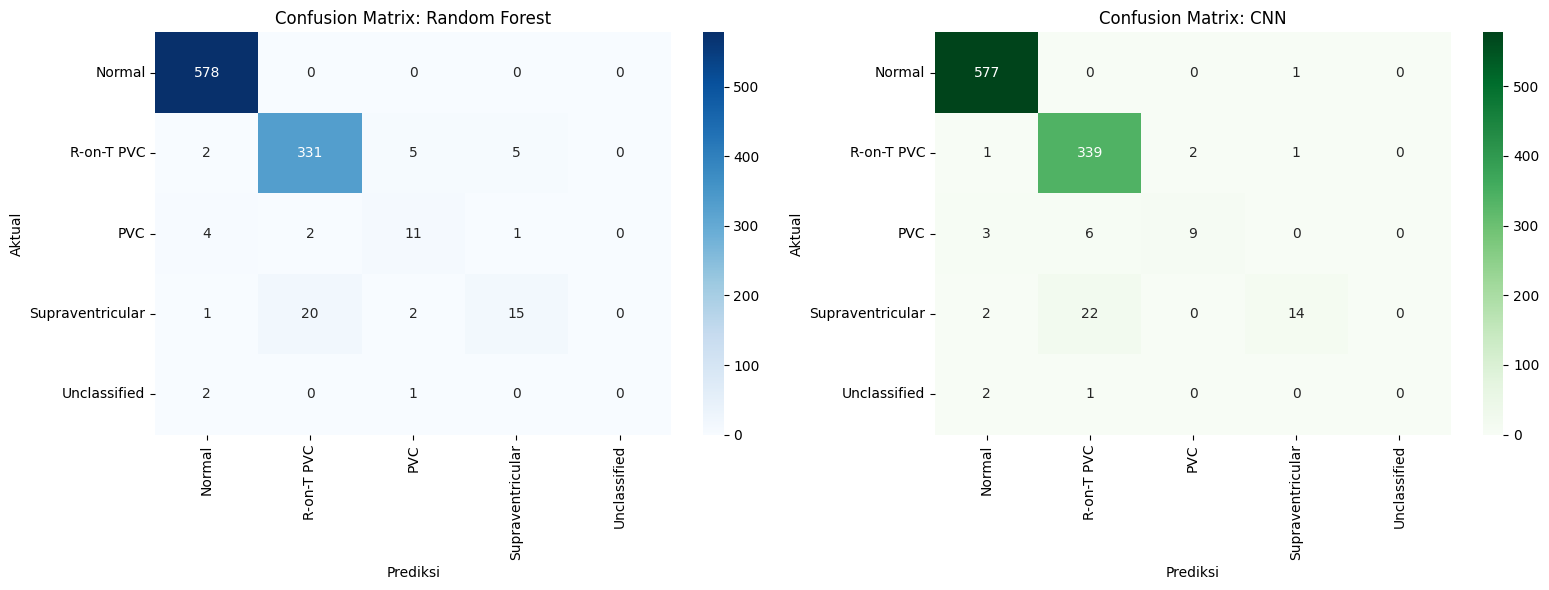

In [29]:
# 3. VISUALISASI CONFUSION MATRIX (SIDE-BY-SIDE)
target_names = ["Normal", "R-on-T PVC", "PVC", "Supraventricular", "Unclassified"]
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# RF Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax[0],
            xticklabels=target_names, yticklabels=target_names)
ax[0].set_title("Confusion Matrix: Random Forest")
ax[0].set_xlabel("Prediksi")
ax[0].set_ylabel("Aktual")

# CNN Matrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens', ax=ax[1],
            xticklabels=target_names, yticklabels=target_names)
ax[1].set_title("Confusion Matrix: CNN")
ax[1].set_xlabel("Prediksi")
ax[1].set_ylabel("Aktual")

plt.tight_layout()
plt.show()

Dominasi Kelas 1 (Normal): kotak kiri atas memiliki angka terbesar (578 sampel), menunjukkan model sangat stabil dalam mengenali detak jantung normal karena jumlah data pelatihannya yang melimpah.

Performa Anomali (Kelas 2-4):
- R-on-T PVC (Kelas 2): Dengan recall 97%, sebagian besar sampel masuk di diagonal utama
- PVC & Supraventricular (Kelas 3-4): terlihat beberapa angka "berceceran" di luar diagonal. Ini menunjukkan morfologi sinyal pada rekaman chf07 untuk kelas ini terkadang memiliki kemiripan visual yang tinggi, sehingga CNN kesulitan membedakannya secara sempurna

Masalah Kelas 5 (Unclassified): Baris terakhir pada sumbu aktual mungkin akan kosong di bagian diagonal (angka 0). Ini mengonfirmasi bahwa model tidak mampu memprediksi satu pun dari 3 sampel asli karena kelangkaan data di PhysioNet.

### **Visualisasi Prediksi Sinyal**

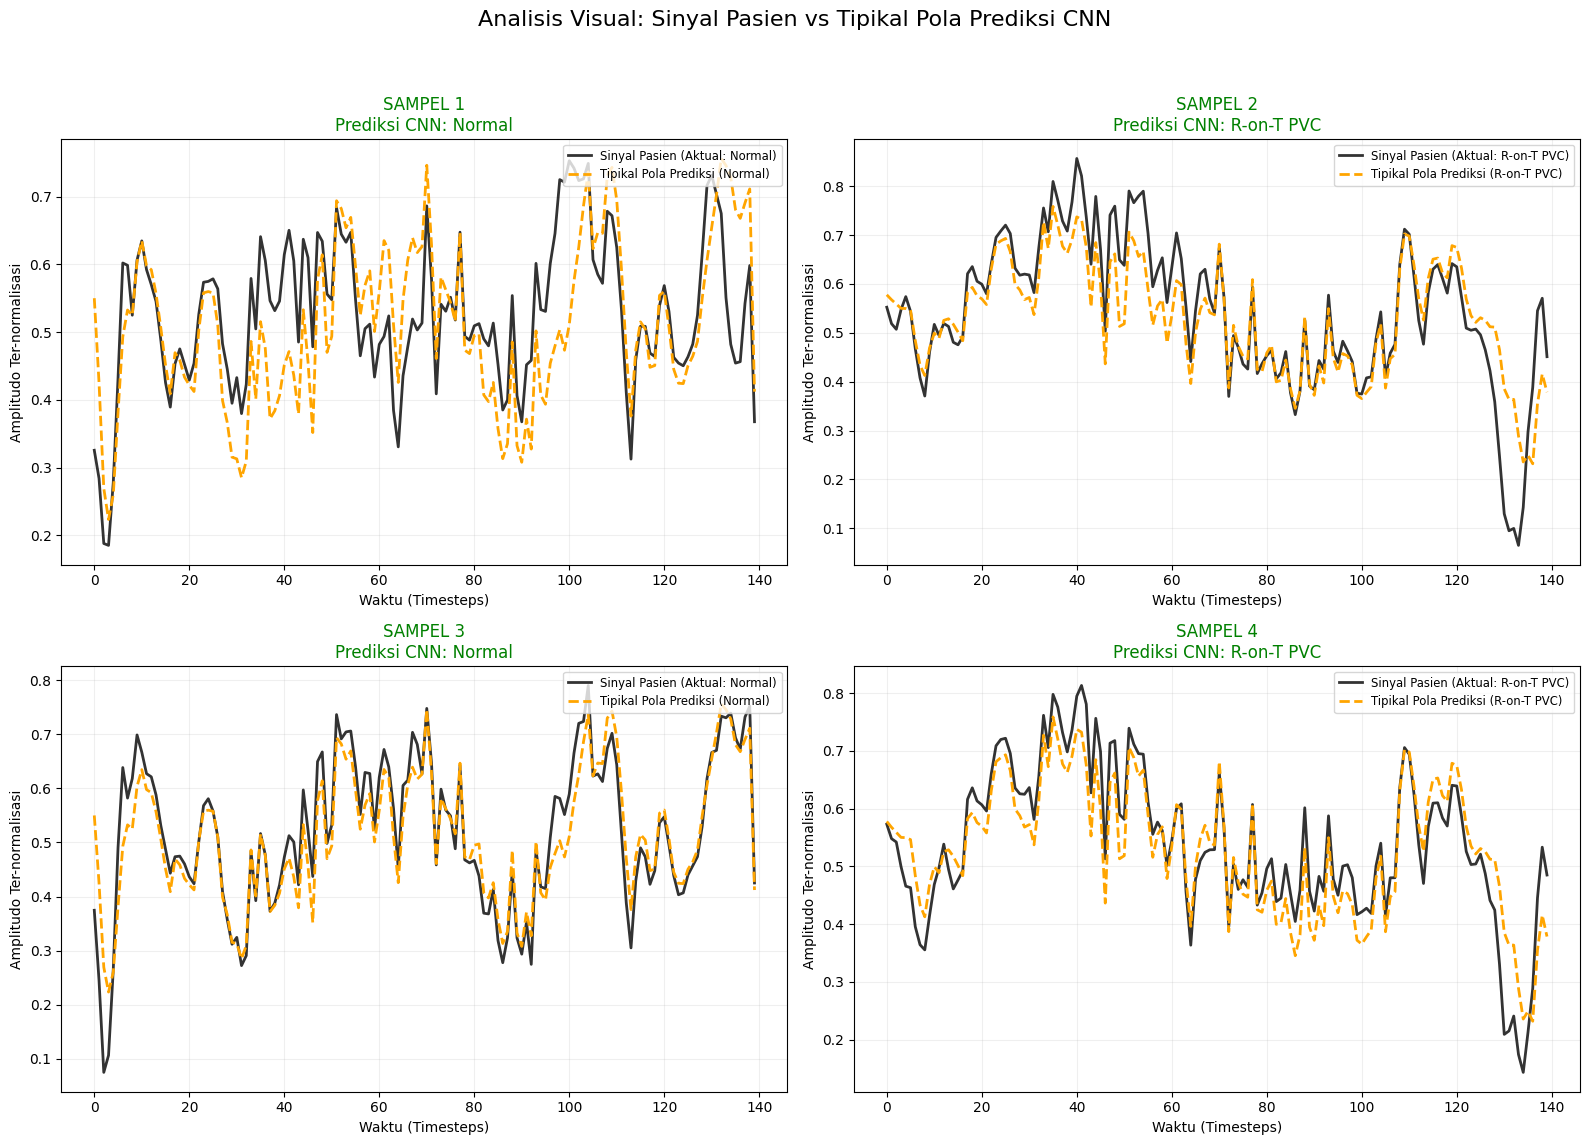

In [30]:
# Menghitung rata-rata sinyal per kelas dari data train untuk perbandingan
# Ini membantu melihat "bentuk standar" dari kelas yang diprediksi
class_means = {}
for i in range(1, 5): # Hanya kelas 1-4 (karena kelas 5 diabaikan)
    class_means[i] = X_train[y_train == i].mean(axis=0).values

plt.figure(figsize=(16, 12))

for i in range(4): # Mengambil 4 sampel pertama dari data test
    plt.subplot(2, 2, i+1)

    # 1. Plot Sinyal Aktual dari User (Data Test)
    actual_idx = int(y_test.iloc[i])
    pred_idx = int(y_pred_cnn[i])

    plt.plot(X_test.iloc[i].values, label=f"Sinyal Pasien (Aktual: {target_names[actual_idx-1]})",
             color='black', linewidth=2, alpha=0.8)

    # 2. Plot Rata-rata Morfologi dari Kelas yang Diprediksi Model
    # Jika prediksi salah, kita bisa melihat perbedaan bentuknya di sini
    if pred_idx in class_means:
        plt.plot(class_means[pred_idx], label=f"Tipikal Pola Prediksi ({target_names[pred_idx-1]})",
                 color='orange', linestyle='--', linewidth=2)

    actual_name = target_names[actual_idx-1]
    pred_name = target_names[pred_idx-1]

    color = 'green' if actual_name == pred_name else 'red'
    plt.title(f"SAMPEL {i+1}\nPrediksi CNN: {pred_name}", fontsize=12, color=color)
    plt.xlabel("Waktu (Timesteps)")
    plt.ylabel("Amplitudo Ter-normalisasi")
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True, alpha=0.2)

plt.suptitle("Analisis Visual: Sinyal Pasien vs Tipikal Pola Prediksi CNN", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

link streamlit: *https://ecg-heartbeat-classification-koli7stxuwvvunofjzpfbj.streamlit.app/*